In [1]:
%env AIBS_RIG_ID = NP.0
# for testing

env: AIBS_RIG_ID=NP.0


In [2]:
# %run pip install --extra-index-url https://pypi.org/simple  --upgrade --quiet np_workflows
%load_ext autoreload
%autoreload 2

import datetime
import pathlib
import time

import IPython
import ipywidgets as widgets

import np_logging
import np_services
import np_workflows

from np_services import (
    Sync, VideoMVR, Cam3d, ScriptCamstim, NewScaleCoordinateRecorder, OpenEphys
)
from np_services.protocols import (
    Pretestable, Initializable, Startable, Testable, Stoppable, Finalizable, Pretestable, Verifiable, Validatable,
    TestError,
    )

logger = np_logging.getLogger()
logger.setLevel('INFO')

np_workflows.elapsed_time_widget()

## Launch apps via RSC

In [ ]:
np_services.start_rsc_apps()

In [4]:
user, mouse = np_workflows.user_and_mouse_widget()

In [ ]:
np_workflows.mtrain_widget(mouse)

ISI map found for 366122:
\\allen\programs\braintv\production\neuralcoding\prod0\specimen_657428270\isi_experiment_659499873\659499873_isi_overlay.tif


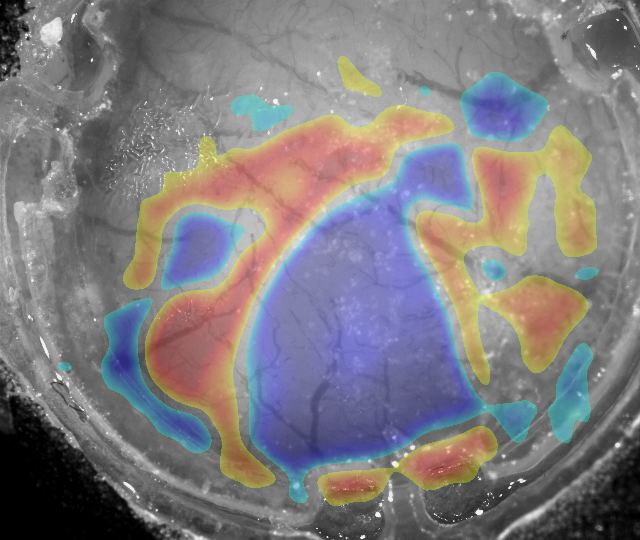

In [4]:
np_workflows.isi_widget(mouse.lims, colormap=True)

In [23]:
np_workflows.widgets.mtrain_widget(mouse)

In [6]:
session: np_session.Session = np_session.generate_session(mouse, user, session_type='ecephys')
display(session)

session_folder = session.npexp_path
session_folder.mkdir(parents=True, exist_ok=True)

# services = (Sync, VideoMVR, Cam3d, OpenEphys, NewScaleCoordinateRecorder, ScriptCamstim)

Session('1245361331_366122_HAB_2023')

# *Pretest*

In [ ]:
OpenEphys.pretest()

In [ ]:
Cam3d.pretest()

In [ ]:
VideoMVR.pretest()

In [ ]:
NewScaleCoordinateRecorder.pretest()

In [ ]:
Sync.pretest()

In [ ]:
ScriptCamstim.pretest() #! needs biscript_pretest_v2 on np3

# *Experiment*

#  **Before putting mouse on stage**

**Open Ephys**
* Record Nodes set to A:/B: (or E:/G: on NP.3)
* Disk space on each Record Node (single long vertical bar)
* 50/50 channels on each Record Node (shorter vertical bars) #!
* Tip-reference on all probes
* Barcodes displaying

**Stage**
* Probes fully retracted, cartridge raised
* Water lines flushed

In [ ]:
ScriptCamstim.script = 'C:/ProgramData/StimulusFiles/dev/oct22_tt_stim_script.py'

ScriptCamstim.params = dict(
)

OpenEphys.folder = session_folder.name

NewScaleCoordinateRecorder.log_root = session_folder

## **Initialize & test services**

In [ ]:
for service in services:
    if isinstance(service, Initializable):
        service.initialize()
    if isinstance(service, Testable):
        service.test()

## **Run sound test**

In [ ]:
ScriptCamstim.params = sound_test_params
ScriptCamstim.start()

while not ScriptCamstim.is_ready_to_start():
    time.sleep(1)

# re-initialize in case sound test produces pkl files that we don't want:
ScriptCamstim.initialize()

# **Dip probes**

## **Photodoc of probes in dye**

In [ ]:
def photodoc(label: str | None) -> pathlib.Path:
    ImageMVR.label = label
    ImageMVR.start()
    ImageMVR.finalize()
    NewScaleCoordinateRecorder.start()
    return ImageMVR.data_files[-1]

IPython.display.Image(photodoc('pre_experiment_surface_image'))

# **Load mouse onto stage**

Before lowering cartridge, check:
* Stabilization screw
* quickcast, agarose/silicon oil
* Tail cone down
* Continuity check


# **Lower cartridge**

## **Photodoc of brain surface**

Turn on light and focus on brain surface

In [ ]:
 IPython.display.Image(photodoc('brain_surface_image'))

# **Insert probes**

## **Photodoc before advancing probes**

Turn on light and focus on brain surface

In [ ]:
IPython.display.Image(photodoc('pre_insertion_surface_image'))

## **Record probe locations and notes**

In [ ]:
from np_probe_targets.implant_drawing import ProbeInsertionsTS5, ProbeTargetInsertionRecordWidget
ProbeInsertionsTS5.save_dir = session_folder
targets = ProbeInsertionsTS5([None] * 6)
IPython.display.display(ProbeTargetInsertionRecordWidget(targets))

## **Photodoc after probes reach target depth**

Turn on light and focus on brain surface

In [ ]:
IPython.display.Image(photodoc('post_insertion_surface_image'))

## **Start settle timer**

In [ ]:
wait_sec = 10 * 60

time_0 = time.time()
time_remaining = lambda: datetime.timedelta(seconds = wait_sec - (time.time() - time_0))
while time_remaining().total_seconds() > 0:
    print(f'{time_remaining()}', end='\r', flush=True)
    time.sleep(.1)

# **Start recording**

In [ ]:
for service in (Sync, VideoMVR, OpenEphys):
    service.start()
    if isinstance(service, Verifiable):
        time.sleep(1)
        service.verify()

# **Start mapping**

In [ ]:
ScriptCamstim.params = mapping_params 

logger.info('Starting mapping')

ScriptCamstim.start()

# time.sleep(10)
# ScriptCamstim.verify() # needs updating to not check filesize

while not ScriptCamstim.is_ready_to_start():
    time.sleep(10)

if isinstance(ScriptCamstim, Finalizable):
    ScriptCamstim.finalize()

logger.info('Mapping complete')

Give mousey a reward to test water delivery

# **Start task**

In [ ]:
ScriptCamstim.initialize()
ScriptCamstim.test()

In [ ]:
ScriptCamstim.script = 'C:/ProgramData/StimulusFiles/dev/oct22_tt_stim_script.py'

ScriptCamstim.params = dict(
)

logger.info('Starting script')

ScriptCamstim.start()

while not ScriptCamstim.is_ready_to_start():
    time.sleep(10)

if isinstance(ScriptCamstim, Finalizable):
    ScriptCamstim.finalize()

## **Stop recording**

In [ ]:
while not ScriptCamstim.is_ready_to_start():
    time.sleep(10)

for service in (_ for _ in (Sync, VideoMVR, OpenEphys) if isinstance(_, Stoppable)):
    service.stop()

for service in (_ for _ in (Sync, VideoMVR, OpenEphys) if isinstance(_, Finalizable)):
    service.finalize()

for service in (_ for _ in (Sync, VideoMVR, OpenEphys) if isinstance(_, Validatable)):
    service.validate()

## **Photodoc post-experiment, before removing probes**

Turn on light and focus on brain surface

In [ ]:
IPython.display.Image(photodoc('post_stimulus_surface_image'))

## **Fully retract probes**

## **Final photodoc of brain surface without probes**

Turn on light and focus on brain surface

In [ ]:
IPython.display.Image(photodoc('post_experiment_surface_image'))

## **Finish up**

* raise cartridge
* add quickcast
* remove and water mouse

## **Copy files**

In [ ]:
import shutil
import contextlib
for service in (Sync, VideoMVR, ImageMVR, ScriptCamstim):
    with contextlib.suppress(AttributeError):
        for file in service.data_files:
            print(service.data_files)
            shutil.copy2(file, session_folder)

In [ ]:
import fabric
password = input(f'Enter password for svc_neuropix:')
for ephys_folder in OpenEphys.data_files:
    fabric.Connection(OpenEphys.host, 'svc_neuropix', password).run(
        f'robocopy {ephys_folder} {session_folder} /j'
    )